# Dummy data
**Goal**: Create dummy data to test the estimator on

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from sklego.loess import LoessSmoother, random_x, generate_noisy_sine_data, plot_windows
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [18]:
np.random.seed(0)
noise_std=2
x, y = generate_noisy_sine_data(noise_std)
model = LinearRegression()

smoother = LoessSmoother(model=model,
                         transform=False,
                         window_method='closest',
                         fixed_window=2,
                         step_size=.2,
                         n_points=10)

smoother.fit(x,y)

smoother.model_per_window
# plot_windows(x,y, smoother.x_focal_base, smoother.y_focal_base, smoother.indices)

array(2.)

# Full plot

ValueError: x and y must be the same size

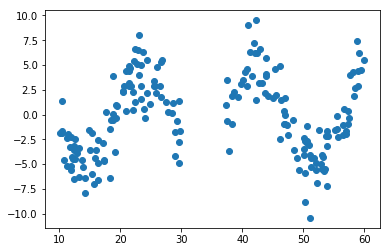

In [11]:
plt.scatter(x, y)
plt.scatter(smoother.x_focal_base,smoother.y_focal_base, c='r', marker='.')

# Old code for reference

In [ ]:
class LoessSmoother:
    def __init__(self,
                 model=LinearRegression(),
                 transform=True,
                 window_method='fixed',
                 fixed_window=2,
                 step_size=.2,
                 n_points=5):
        """"""
        self.model = model
        self.transform = transform
        self.window_method = window_method
        self.fixed_window = fixed_window
        self.step_size = step_size
        self.n_points = n_points
        
    def fit(self, x, y):
        self.x_focal_base = self._get_x_focal_base(x)
        self.indices = self._get_window_indices(x)
        self.y_focal_base, self.model_per_window = self._fit_model_per_window(x, y)
    
    def _get_x_focal_base(self, x):
        """"""
        if self.transform:
            return np.sort(x)
        else:
            x_focal_base = np.array([np.min(x)])
            while x_focal_base.max() < np.array(x).max():
                x_focal_base = np.append(x_focal_base, x_focal_base[-1] + self.step_size)
            return x_focal_base

    def _get_window_indices(self, x):
        indices = {}

        for index, x_focal in enumerate(self.x_focal_base):
            
            if self.window_method == 'fixed':
                x_indices = np.argwhere((x > (x_focal - self.fixed_window)) & (x < (x_focal + self.fixed_window)))

                if len(x_indices) > 2*self.n_points:
                    indices[index] = x_indices
                else: # If the number of returned indices is too small, resort to nearest points
                    indices[index] = x_indices
                    
            if self.window_method == 'closest':
                x_focal = np.asarray([x_focal]).reshape(-1, 1)
                knn = NearestNeighbors(n_neighbors=self.n_points).fit(x.reshape(-1, 1))
                indices[index] = knn.kneighbors(x_focal)[1][0]

        return indices
        
    def _fit_model_per_window(self, x, y):
        model_per_window = []
        y_focal_base = []

        for index in self.indices.keys():
            x_focal = np.asarray([self.x_focal_base[index]]).reshape(-1,1)
            x_window = x[self.indices[index]].reshape(-1,1)
            y_window = y[self.indices[index]].reshape(-1,1)

            # Development purposes: catch error during fit when x_window is empty
            try:
                # TODO: implement iterative weighted fit
                model = self.model.fit(x_window, y_window, sample_weight=None)
                y_focal_base.append(model.predict(x_focal))
                model_per_window.append(model)
            except ValueError:
                y_focal_base.append(np.asarray([np.mean(y_focal_base)]))
                model_per_window.append(None)

        return y_focal_base, model_per_window
        

def plot_windows(x, y, x_focal_base, y_focal_base, indices):
    for index in indices.keys():
        ax = plt.axes(xlim=(np.min(x), np.max(x)), ylim=(np.min(y), np.max(y)))
        ax.scatter(x[indices[index]],y[indices[index]])
        ax.scatter(x_focal_base[index], y_focal_base[index], c='r')
        ax.set_title(f'Window for {x_focal_base[index]}')
        plt.pause(0.01)
        plt.show()
            
        
    
# Loop over x_focal_base and fit models -> list of models

